In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import HDBSCAN

SEED = 42

In [46]:
train_projects = pd.read_csv('../data/train_projects.csv')
test_projects = pd.read_csv('../data/test_projects.csv')

In [49]:
train_projects = train_projects.set_index('project_code')
test_projects = test_projects.set_index('project_code')

In [2]:
test_measurements = pd.read_csv('../../test_measurements.csv')
train_measurements = pd.read_csv('../../train_measurements.csv')

In [3]:
full_measurements = pd.concat([test_measurements, train_measurements], axis=0)

In [4]:
full_measurements.shape[0]

23482

In [38]:
len(list(np.unique(full_measurements.project_code)))

3178

In [5]:
db = HDBSCAN(min_cluster_size=20)\
        .fit(list(zip(full_measurements.med_freq)))

In [6]:
np.unique(db.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [22]:
full_measurements['cluster'] = db.labels_ + 1

### Summarize and visualize DBSCAN results

In [32]:
labels = db.labels_ + 1

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1)
n_points = len(list(labels))
n_noise = list(labels).count(0)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f"Noise proportion: {n_noise/n_points}")
print(f'Signal proportion: {1-(n_noise/n_points)}')

Estimated number of clusters: 342
Total number of measurements: 23482
Estimated number of noise measurements: 5899
Noise proportion: 0.2512136955966272
Signal proportion: 0.7487863044033728


In [33]:
full_measurements.groupby('cluster').count().project_title.sort_values(ascending=False).head(20)

cluster
0      5899
10      208
6       200
9       193
44      176
324     161
41      152
76      146
339     141
180     140
11      136
256     130
301     128
143     122
17      120
137     118
261     116
125     115
338     114
291     112
Name: project_title, dtype: int64

In [11]:
full_measurements[full_measurements.cluster == 341].med_freq.describe()

count    4.600000e+01
mean     2.313200e+02
std      5.747154e-14
min      2.313200e+02
25%      2.313200e+02
50%      2.313200e+02
75%      2.313200e+02
max      2.313200e+02
Name: med_freq, dtype: float64

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='med_freq', ylabel='Density'>

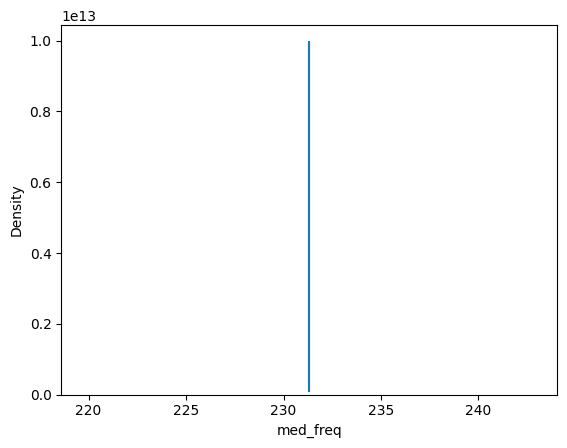

In [12]:
sns.kdeplot(full_measurements[full_measurements.cluster == 341].med_freq)

### Create ground-truth vectors for DBSCAN cluster by project

#### Group by project id

In [34]:
proj_meas = full_measurements.groupby('project_code').agg({
    'cluster': lambda x: x.to_list()
})

In [35]:
def generate_gt(frame:pd.DataFrame, label_column:str, labs:np.array, normalize=True): 
    '''
    Function that generates ground truth vectors for projects by taking a data frame,
    a string representing the column name that has a list of labels for each measurement,
    and the raw lables from a clustering algorithm

    PARAMETERS:
    
    frame: `pd.DataFrame` indexed by project_code that has a column with list of measurment labels

    label_column: `str` name of column to base ground truth vector off of

    labs: `np.ndarray` of lables generated by clustering algorithm

    normalize: `bool` to normalize vector by sum of values to get probability vector. Defaults to `True`

    OUTPUTS:

    gt_list: `list` of `np.array` ground truth vectors
    '''  
    # gt_list = []
    # for proj in frame.index.values:
    #     arr = np.zeros(len(set(list(labs))))
    #     proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
    #     for idx in proj_labs.index:
    #         arr[idx] = proj_labs[idx]
    #     if normalize:
    #         arr = arr/arr.sum()
    #     gt_list.append(np.array(arr))
    # return gt_list

    gt_dict = {}
    for proj in frame.index.values:
        arr = np.zeros(len(set(list(labs))))
        proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
        for idx in proj_labs.index:
            arr[idx] = proj_labs[idx]
        if normalize:
            arr = arr/arr.sum()
        gt_dict[proj] = np.array(arr)
    return gt_dict

#### Check that we ground truth vectors for number of projects

In [36]:
ground_truth = generate_gt(proj_meas, 'cluster', db.labels_, normalize=True)
len(ground_truth)

3178

In [39]:
gt_frame = pd.DataFrame(ground_truth).sort_index(ascending=True).T
gt_frame

,0,1,2,3,4,5,6,7,8,9,...,333,334,335,336,337,338,339,340,341,342
2011.0.00010.S,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00017.S,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00028.S,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00039.S,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00046.S,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023.1.01710.S,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023.1.01720.S,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023.1.01721.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023.A.00003.S,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
gt_frame.iloc[1].sum()

1.0

In [40]:
gt_frame[gt_frame[342] >0]

,0,1,2,3,4,5,6,7,8,9,...,333,334,335,336,337,338,339,340,341,342
2012.1.00647.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.500000
2013.1.00537.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000
2013.1.00879.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.083333,0.083333,0.083333,0.0,0.083333,0.083333
2013.1.01086.S,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.100000,0.0,0.000000,0.100000
2013.1.01195.S,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.142857
2015.1.00025.S,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.083333,0.000000,0.0,0.000000,0.083333
2015.1.00331.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.250000,0.0,0.000000,0.250000
2015.1.00340.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.166667
2015.1.00815.S,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.166667,0.000000,0.000000,0.0,0.000000,0.166667
2015.1.01253.S,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.071429


### Add ground truth labels to projects

In [43]:
gt_frame = gt_frame.apply(lambda x: x.to_list(), axis=1).to_frame()

In [44]:
gt_frame.columns = ['gt_vec']
gt_frame.head()

,gt_vec
2011.0.00010.S,"[0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2011.0.00017.S,"[0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2011.0.00028.S,"[0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2011.0.00039.S,"[0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2011.0.00046.S,"[0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Add ground truths to train and test projects

In [54]:
train_projects = train_projects.join(gt_frame, how='left')
test_projects = test_projects.join(gt_frame, how='left')

In [58]:
train_projects.to_csv('bert_hdbscan_train.csv')
test_projects.to_csv('bert_hdbscan_test.csv')